In [1]:
import scipy as sc, scipy.io
import numpy as np
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized
import functions_grid
import functions_realistic
import functions_plot

from netCDF4 import Dataset

# Procedure in final_bathymetry.ipynb

The goal is to create a no canyon bathymetry for my current resolution (September 27th = (258, 193)). However, the smoothing process takes some time. Therefore, I'm starting off with a lower resolution and then apply the new process on a high resolution domain.

In [2]:
#doubling resolution Jan 26
#quadrupling resolution Jun 28
x_final =  150 #483#120 * 4
y_final =  int(0.75 * x_final)#363#int(0.75 * x_final)

extension_m = 90000#108061

smooth_factor = 0.2
max_norm_depth_diff = 0.70834736504

search_x = [-1000000, -1450000, -1750000, -1400000]

In [3]:
x_final, y_final

(150, 112)

In [4]:
x_region, y_region, z_region = functions_plot.def_regionS()
cmap, norm = functions_plot.Colormap()

In [5]:
x_wall, y_wall, fluid_depth = functions_idealized.base_measurements()

In [6]:
lon_s_corners_can, lat_s_corners_can = functions_grid.match_domain(x_wall, y_wall, search_x)

In [7]:
x_wall_ext = x_wall + extension_m

In [8]:
lon_s_corners, lat_s_corners = functions_grid.match_domain(x_wall_ext, y_wall, search_x)

In [9]:
lon_g_corners, lat_g_corners = functions_grid.transform_coords(lon_s_corners, lat_s_corners, 'SG')

lonW, latW, lonE, latE = functions_grid.get_southern_points(lon_g_corners, lat_g_corners)

lon_g_grid, lat_g_grid = functions_grid.create_grid(x_final, y_final, lonW, latW, lonE, latE)

lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')

dx (distance between the corner southern point and its neighbour) [km]: 3.47194656891
dx2 (distance between the corner northern point and its neighbour) [km]: 3.4655773447


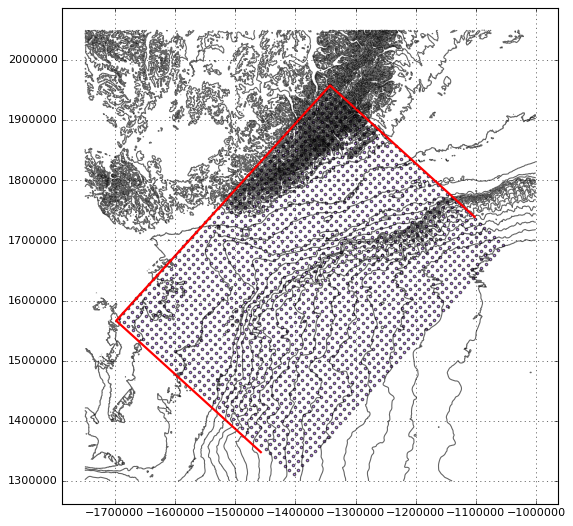

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.scatter(lon_s_grid[::3,::3], lat_s_grid[::3,::3], c='BlueViolet', s=5, alpha=0.6)
ax.plot(lon_s_corners, lat_s_corners, 'r', linewidth=2)

In [11]:
dx = functions_grid.find_dx(lon_g_grid, lat_g_grid)
index = int(extension_m / (dx * 1000))

In [12]:
z_positive = functions_realistic.canyon_for_model(fluid_depth, index, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

In [13]:
z_original, z_smoothed = functions_realistic.smooth_canyon(max_norm_depth_diff, smooth_factor, z_positive)

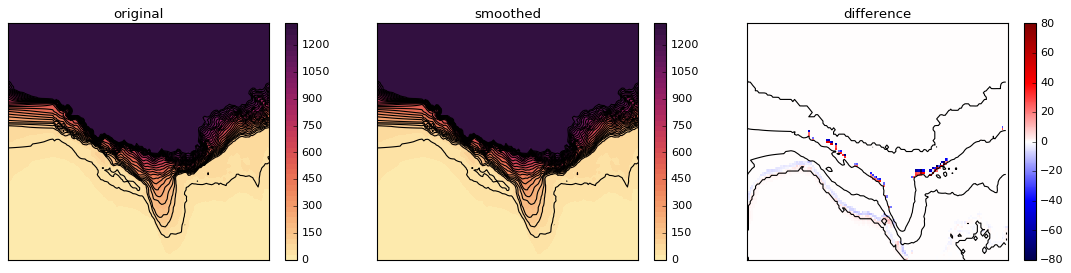

In [14]:
difference = np.subtract(z_smoothed, z_original)
fig, axes = plt.subplots(1,3,figsize=(14,3.5)); plt.tight_layout()
c0 = axes[0].contourf(z_original, 50, cmap = cmo.cm.matter)
c1 = axes[1].contourf(z_smoothed, 50, cmap = cmo.cm.matter)
c2 = axes[2].pcolormesh(difference, cmap = cm.seismic, vmin=-80, vmax=80)
axes[0].contour(z_original, 25, linestyles='solid', colors = 'k')
axes[1].contour(z_smoothed, 25, linestyles='solid', colors = 'k')
axes[2].contour(z_original, levels = [0, 40, 80, 1299], colors='k',linestyles='-')
for cs, i, ttl in zip([c0, c1, c2], np.arange(3), ['original', 'smoothed', 'difference']):
    fig.colorbar(cs, ax = axes[i]); axes[i].set_title(ttl)
    axes[i].xaxis.set_visible(False); axes[i].yaxis.set_visible(False)

# Closer look at realistic canyon

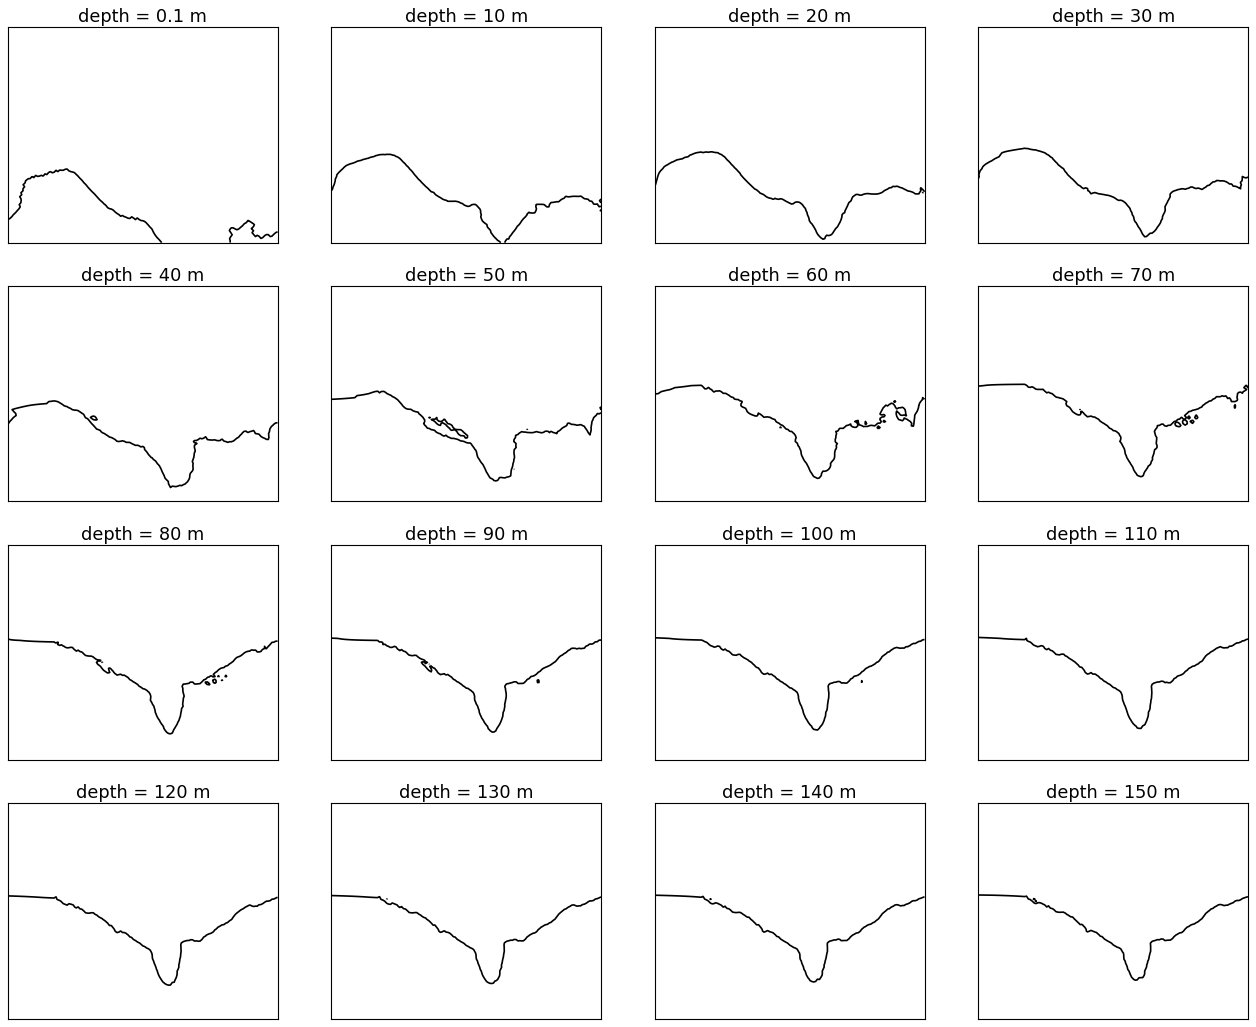

In [15]:
fig, axes = plt.subplots(4, 4, figsize = (20, 16))
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        ax.contour(z_smoothed, levels = [0.1], colors='k',linestyles='-', linewidths=1.5)
        title = 0.1
    else:
        ax.contour(z_smoothed, levels = [i*10], colors='k',linestyles='-', linewidths=1.5)
        title = i*10
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_title('depth = '+str(title)+' m', fontsize=16)

In [16]:
np.unique(z_smoothed).shape

(9525,)

In [17]:
z_smoothed.shape

(109, 147)

In [18]:
def explore_conditions(min_bathy, max_bathy):
    
    inds = np.where((z_smoothed > min_bathy) & (z_smoothed < max_bathy))
    indsx = inds[1]
    indsy = inds[0]
    
    bathy_sub = np.zeros(len(indsx))
    for n in range(len(indsx)):
        bathy_sub[n] = z_smoothed[indsy[n], indsx[n]]
        
    return indsx, indsy, bathy_sub

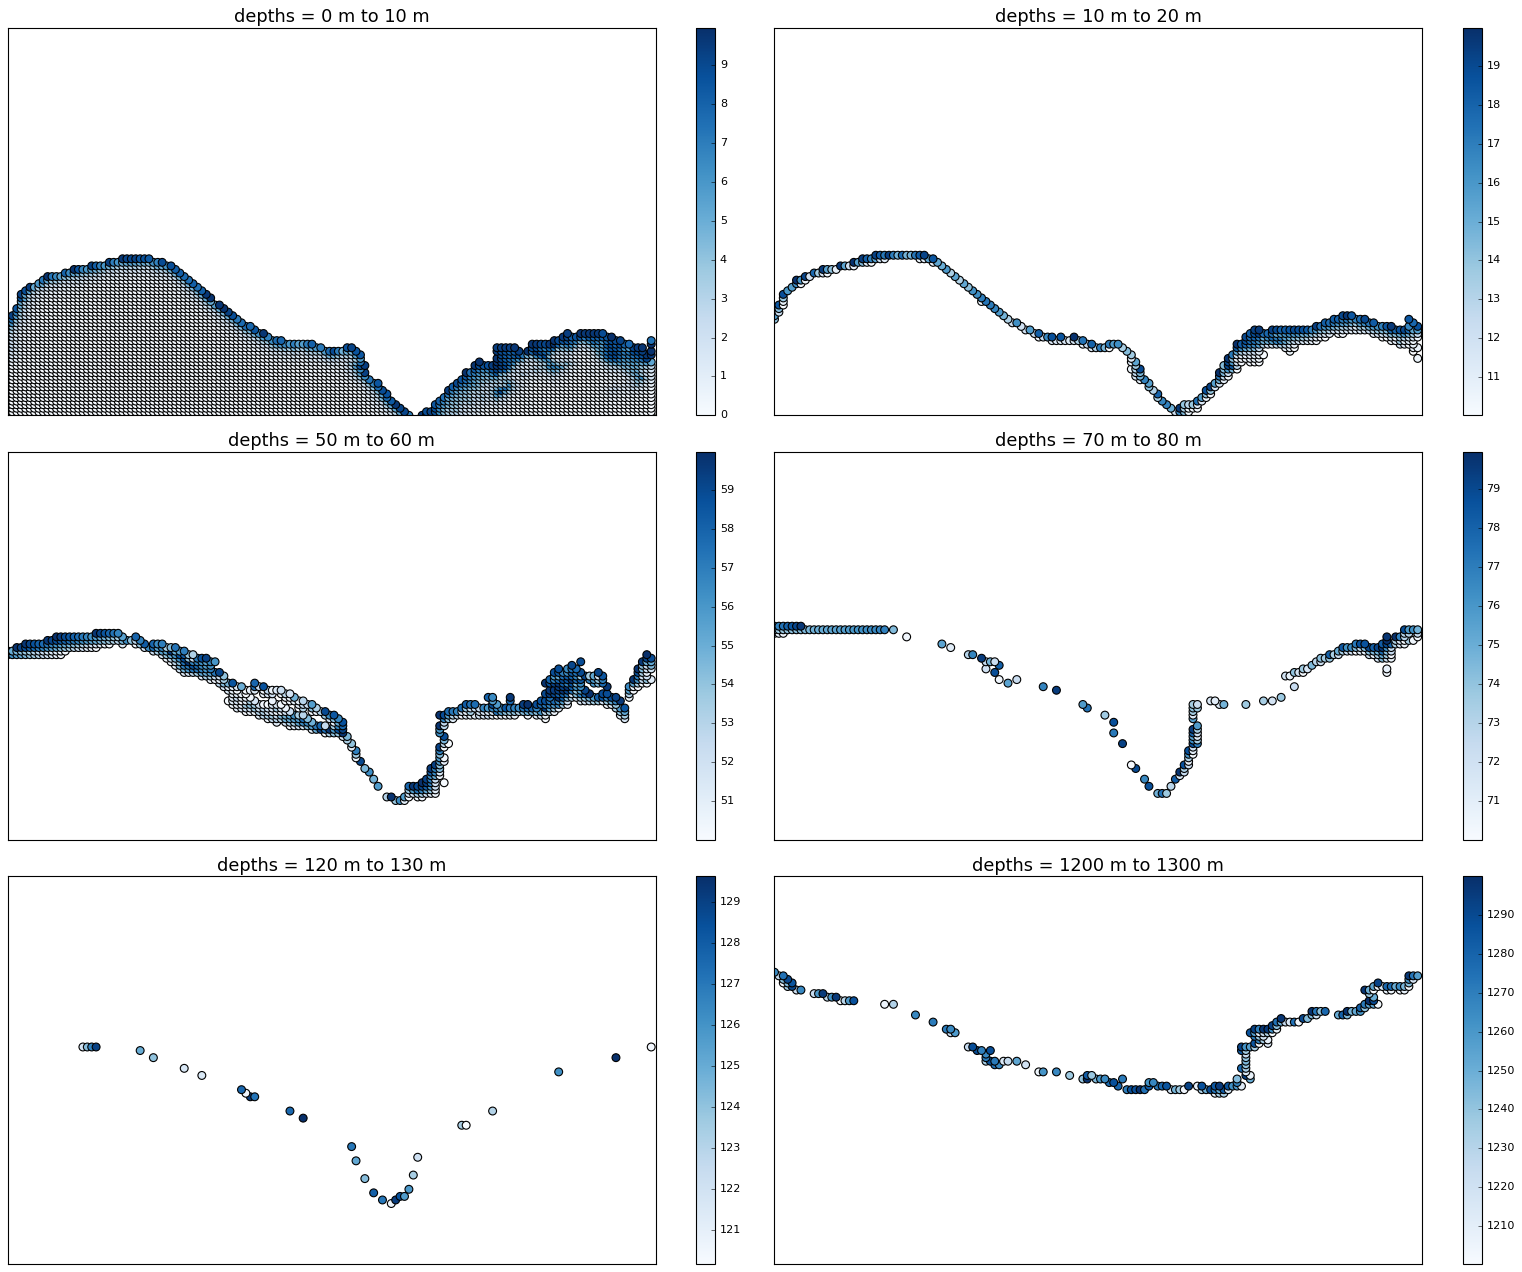

In [19]:
limits_all = [[0, 10], [10, 20], [50, 60], [70, 80], [120, 130], [1200, 1300]]

fig, axes = plt.subplots(3, 2, figsize = (20, 16))
for ax, limits in zip(axes.flatten(), limits_all):
    min_bathy = limits[0]
    max_bathy = limits[1]
    indsx, indsy, bathy_sub = explore_conditions(min_bathy, max_bathy)
    sc = ax.scatter(indsx, indsy, c = bathy_sub, cmap=cm.Blues, s=50)
    ax.set_title('depths = ' + str(min_bathy) + ' m to ' + str(max_bathy) + ' m', fontsize=16)
    
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_ylim([0, z_smoothed.shape[-2]])
    ax.set_xlim([0, z_smoothed.shape[-1]])
    fig.colorbar(sc, ax=ax)
fig.tight_layout(w_pad = 0.1)

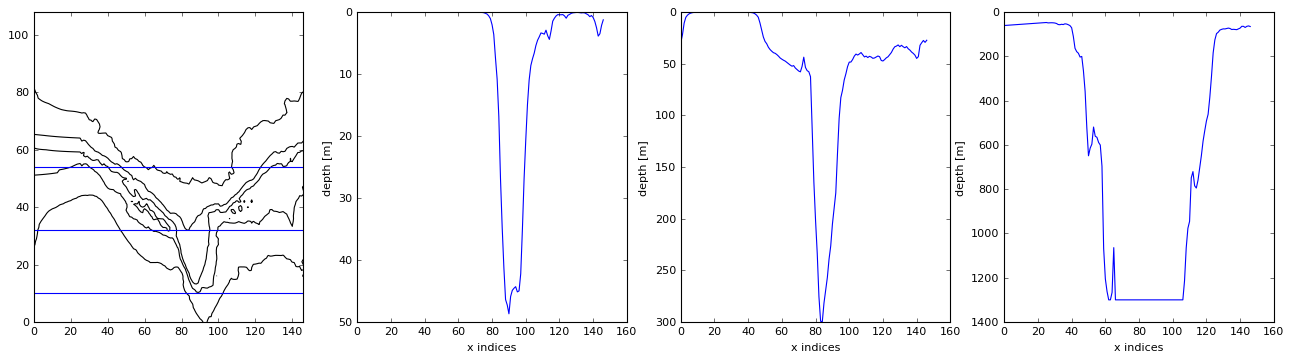

In [20]:
fig, (ax1, ax2, ax3, ax4)  = plt.subplots(1, 4, figsize = (20, 5))
for ax, n in zip([ax2, ax3, ax4], [0.1, 0.3, 0.5]):
    j = int((z_smoothed.shape[-2]) * n)
    ax1.axhline(j)
    depth_profile = np.zeros(z_smoothed.shape[-1])
    for i in range(z_smoothed.shape[-1]):
        depth_profile[i] = z_smoothed[j, i]
    ax.plot(depth_profile)
    ax.set_ylabel('depth [m]')
    ax.set_xlabel('x indices')
    ax.invert_yaxis()
ax1.contour(z_smoothed, levels = [10, 50, 80, 300, 1200], colors='k',linestyles='-')

In [145]:
z_previous = np.copy(z_smoothed)
z_beside = np.copy(z_smoothed)

slopes = np.zeros([z_smoothed.shape[-2], z_smoothed.shape[-1]-1])

thresholdA = 3
thresholdB = -0.001

for j in range(z_smoothed.shape[-2]):
    for i in range(z_smoothed.shape[-1] - 1):
        slopes[j, i] = z_smoothed[j, i+1] - z_smoothed[j, i]
        
        if abs(slopes[j, i]) > thresholdA:
            z_previous[j, i+1] = z_previous[j, i]
            
        if slopes[j, i] > thresholdA:
            z_beside[j, i+1] = z_beside[j, i]
            
        elif slopes[j, i] > thresholdB:
            z_beside[j, i] = z_beside[j, i+1]

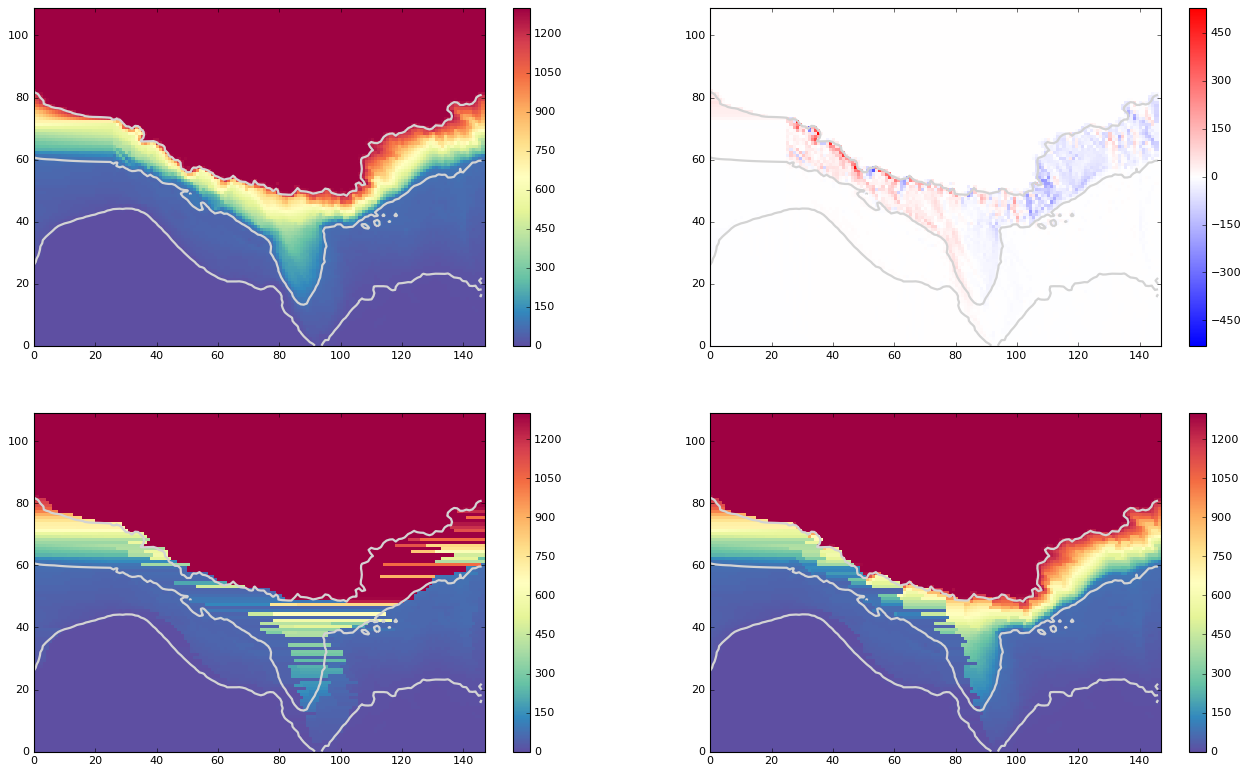

In [146]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(20,12))
p1 = ax1.pcolormesh(z_smoothed, cmap=cm.Spectral_r)

vm = np.max([abs(slopes), abs(slopes)])
p2 = ax2.pcolormesh(slopes, cmap=cm.bwr, vmin=-1*vm, vmax=vm)

p3 = ax3.pcolormesh(z_previous, cmap=cm.Spectral_r)

p4 = ax4.pcolormesh(z_beside, cmap=cm.Spectral_r)

for n, p, ax in zip(np.arange(4), [p1, p2, p3, p4], [ax1, ax2, ax3, ax4]):
    fig.colorbar(p, ax=ax)
    ax.set_xlim([0, z_nocanyon.shape[-1]])
    ax.set_ylim([0, z_nocanyon.shape[-2]])
    ax.contour(z_smoothed, levels=[10, 80, 1250], colors='lightgray', linewidths=2)

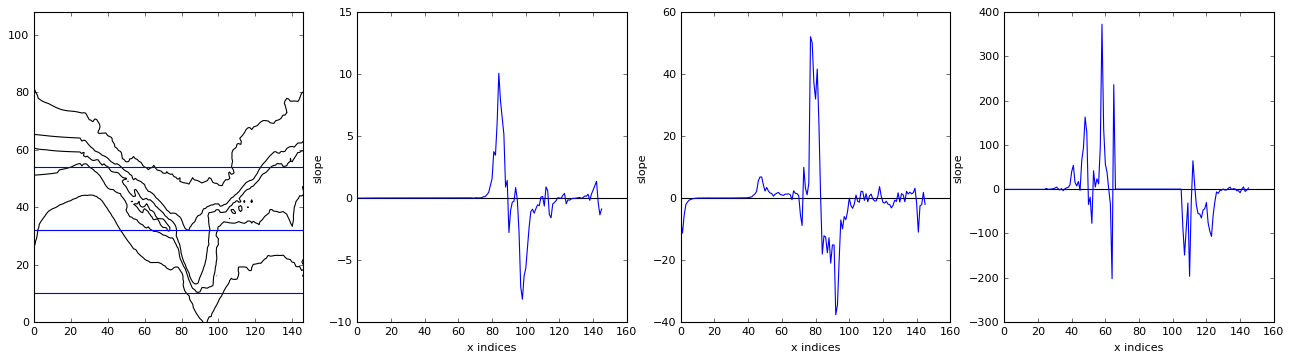

In [150]:
fig, (ax1, ax2, ax3, ax4)  = plt.subplots(1, 4, figsize = (20, 5))
ax1.contour(z_smoothed, levels = [10, 50, 80, 300, 1200], colors='k',linestyles='-')
for ax, n in zip([ax2, ax3, ax4], [0.1, 0.3, 0.5]):
    j = int((slopes.shape[-2]) * n)
    ax1.axhline(j)
    ax.axhline(0, c='k')
    ax.plot(slopes[j, :])
    ax.set_ylabel('slope')
    ax.set_xlabel('x indices')

In [155]:
if -5 < -0.5:
    print('True')
else:
    print('False')

True
